# Alignment Quantification
This notebook is meant to quantitatively measure the effects of our alignment algorithm.

It uses both the mean square error (MSE) and a structural similarity measure (SSIM) to measure the effectiveness of our alignment algorithm and to compare the performance of ORB and SIFT keypoint detections. ORB provides very slight improvements and runs faster so we use that for the rest of the project.

In the comparison between ORB and SIFT, another metric was used. It was the ratio of the number of keypoints kept by RANSAC to the number of keypoints found by the SIFT or ORB.
Higher ratio is interpreted as better as it suggest that more of the matches that were found by the keypoint detection algorithm were useful in creating the homographic projection for alignment.

In [153]:
import cv2

from alignment import get_image_alignment_transform
from alignment import apply_transform
from alignment import crop_zero_sides
from dataset_navigation import get_image_paths
import rawpy
from raw_utils import pack_raw
import numpy as np
from tqdm import tqdm 
import skimage


## Calculate statistics for aligned images

In [36]:

def calculate_alignment_statistics( method: str ):
    raw_image_paths = get_image_paths()
    long_exp_paths = raw_image_paths['long_exp']
    filtered_paths = raw_image_paths['filter_long_exp']
    n = len(long_exp_paths)
    ratios = np.zeros(n)
    mses = np.zeros(n)
    ssims = np.zeros(n)
    for idx, (long_path, filtered_path) in tqdm(enumerate(zip(long_exp_paths, filtered_paths)), total=n):
        # Load raw images into 4 channels
        long_packed = pack_raw(rawpy.imread(long_path).raw_image_visible)
        filtered_packed = pack_raw(rawpy.imread(filtered_path).raw_image_visible)
        # Rescale for alignment algs
        long_g = (long_packed[:,:,1]/long_packed[:,:,1].max()*255).astype(np.uint8)
        filtered_g = (filtered_packed[:,:,1]/filtered_packed[:,:,1].max()*255).astype(np.uint8)
        # Align and crop
        try:
            H, ratio = get_image_alignment_transform(long_g, filtered_g, method, return_ratio=True)
            aligned = apply_transform(long_packed, filtered_packed, H)
            long_packed, aligned = crop_zero_sides(long_packed, aligned, 100)
        except Exception as e:
            mses[idx] = -1
            ssims[idx] = -1
            ratios[idx] = -1
            print("Skipping because of:", e)
            continue
        # Calculate metrics
        diff = long_packed.astype(np.float64) - aligned.astype(np.float64)
        mses[idx] = np.mean(diff**2)
        ssims[idx] = skimage.metrics.structural_similarity(long_packed, aligned, channel_axis=2)
        ratios[idx] = ratio
        
    return ratios, ssims, mses
    

In [28]:
ratios_orb, ssims_orb, mses_orb = calculate_alignment_statistics('orb')


100%|██████████| 77/77 [02:10<00:00,  1.69s/it]


In [45]:
ratios_sift, ssims_sift, mses_sift = calculate_alignment_statistics('sift')


 48%|████▊     | 37/77 [01:37<01:32,  2.30s/it]

Skipping because of: Not enough matches (6) for homography.


 83%|████████▎ | 64/77 [02:44<00:29,  2.25s/it]

Skipping because of: Not enough matches (4) for homography.


100%|██████████| 77/77 [03:16<00:00,  2.56s/it]


In [39]:
def sanitize(array):
    return array[array!=-1]
ratios_orb = sanitize(ratios_orb)
ssims_orb = sanitize(ssims_orb)
mses_orb = sanitize(mses_orb)
ratios_sift = sanitize(ratios_sift)
ssims_sift = sanitize(ssims_sift)
mses_sift = sanitize(mses_sift)


## Calculate statistics for unaligned images

In [155]:
# Same statistics but on unaligned images:
def calculate_unalignment_statistics():
    raw_image_paths = get_image_paths()
    long_exp_paths = raw_image_paths['long_exp']
    filtered_paths = raw_image_paths['filter_long_exp']
    n = len(long_exp_paths)
    mses = np.zeros(n)
    ssims = np.zeros(n)
    for idx, (long_path, filtered_path) in tqdm(enumerate(zip(long_exp_paths, filtered_paths)), total=n):
        # Load raw images into 4 channels
        long_packed = pack_raw(rawpy.imread(long_path).raw_image_visible)
        filtered_packed = pack_raw(rawpy.imread(filtered_path).raw_image_visible)
        # Calculate metrics
        diff = long_packed.astype(np.float64) - filtered_packed.astype(np.float64)
        mses[idx] = np.mean(diff**2)
        ssims[idx] = skimage.metrics.structural_similarity(long_packed, filtered_packed, channel_axis=2)
    return ssims, mses

In [156]:
ssims, mses = calculate_unalignment_statistics()

100%|██████████| 77/77 [02:01<00:00,  1.58s/it]


## Performances compared

In [158]:
print("Mean ratio [ORB]:", ratios_orb.mean(), "(higher is better)")
print("Mean ratio [SIFT]:", ratios_sift.mean(), "(higher is better)")
print("Mean SSIM [ORB]:", ssims_orb.mean(), "(higher is better)")
print("Mean SSIM [None]:", ssims.mean(), "(higher is better)")
print("Mean SSIM [SIFT]:", ssims_sift.mean(), "(higher is better)")
print("Mean SSIM [None]:", ssims_sift.mean(), "(higher is better)")
print("Mean MSE [None]:", mses.mean(), "(lower is better)")
print("Mean MSE [ORB]:", mses_orb.mean(), "(lower is better)")
print("Mean MSE [SIFT]:", mses_sift.mean(), "(lower is better)")

Mean ratio [ORB]: 0.8113638830205411 (higher is better)
Mean ratio [SIFT]: 0.7078840678375469 (higher is better)
Mean SSIM [ORB]: 0.9887630179117572 (higher is better)
Mean SSIM [None]: 0.9621829025018456 (higher is better)
Mean SSIM [SIFT]: 0.9311361135632926 (higher is better)
Mean SSIM [None]: 0.9311361135632926 (higher is better)
Mean MSE [None]: 1470965.9330760096 (lower is better)
Mean MSE [ORB]: 317084.15090020536 (lower is better)
Mean MSE [SIFT]: 321847.1979154305 (lower is better)


In [159]:
# header
print(f"{'Idx':>3}  {'ORB R':>7}  {'ORB SSIM':>9}  {'ORB MSE':>9}   |   {'SIFT R':>7}  {'SIFT SSIM':>9}  {'SIFT MSE':>9}")
print("-"*80)

# rows
for i, (ro, so, mo, rs, ss, ms) in enumerate(zip(
        ratios_orb, ssims_orb, mses_orb,
        ratios_sift, ssims_sift, mses_sift)):
    print(f"{i:3d}  {ro:7.3f}  {so:9.3f}  {mo:9.2f}   |   {rs:7.3f}  {ss:9.3f}  {ms:9.2f}")

Idx    ORB R   ORB SSIM    ORB MSE   |    SIFT R  SIFT SSIM   SIFT MSE
--------------------------------------------------------------------------------
  0    0.750      0.979  847291.87   |     0.665      0.978  865551.16
  1    0.905      0.976  444442.40   |     0.791      0.977  451022.73
  2    0.687      0.985  447662.25   |     0.780      0.985  448148.37
  3    0.499      0.972  910332.43   |     0.547      0.973  905366.47
  4    0.344      0.888  2841478.52   |     0.457      0.936  1566949.19
  5    0.931      0.988  866150.26   |     0.781      0.988  862936.97
  6    0.975      0.990  259843.72   |     0.895      0.990  259638.60
  7    0.860      0.992  199075.78   |     0.871      0.992  196578.77
  8    0.935      0.998   22068.14   |     0.865      0.998   21256.86
  9    0.778      0.973  393702.89   |     0.506      0.978  372360.83
 10    0.737      0.991  194232.43   |     0.653      0.991  194510.50
 11    0.906      0.996   35419.67   |     0.851      0.995   375

### From here on out we only compare the results from ORB to the unaligned images

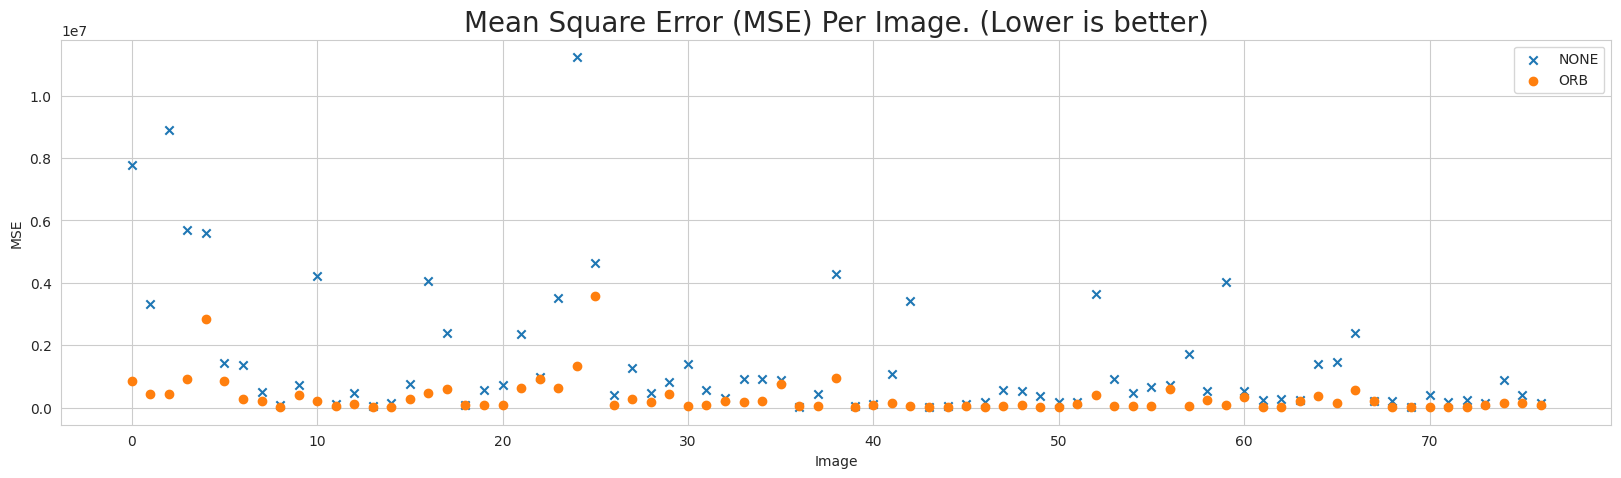

In [168]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20,5))
# plt.yscale('log')
plt.scatter(range(len(mses_sift)), mses, label="NONE", marker='x')
plt.scatter(range(len(mses_orb)), mses_orb, label="ORB")
# plt.scatter(range(len(mses_sift)), mses_sift, label="SIFT")
plt.legend()
plt.title("Mean Square Error (MSE) Per Image. (Lower is better)", {'fontsize':20})
plt.xlabel("Image")
plt.ylabel("MSE")
plt.show()

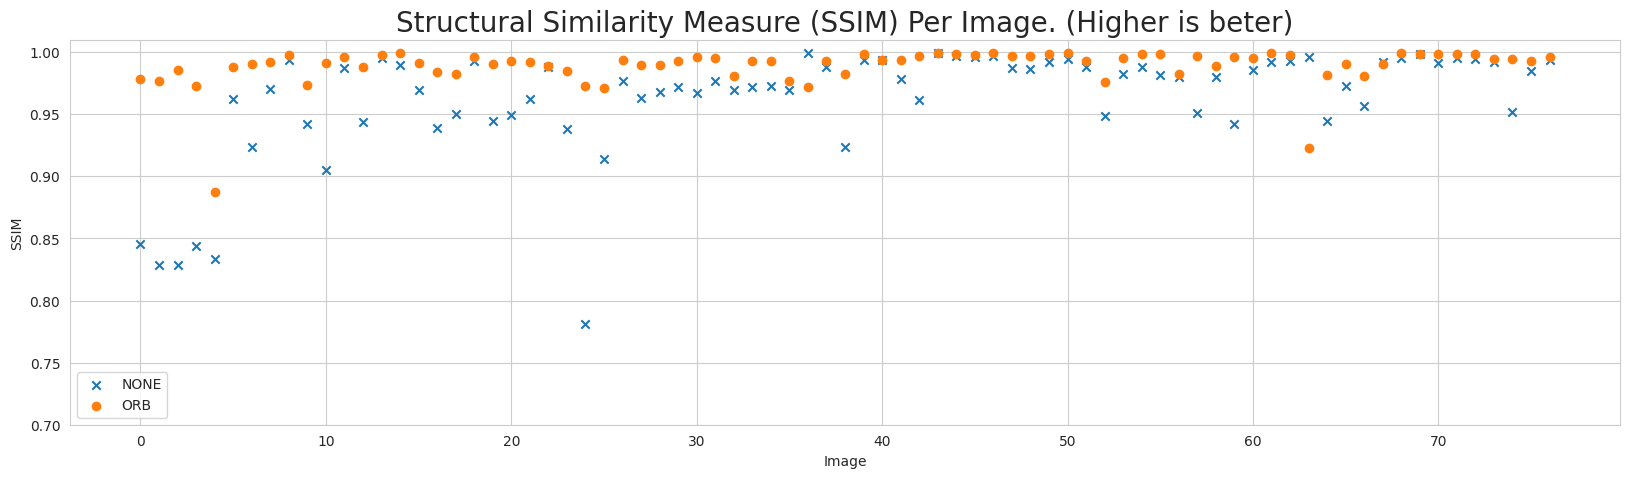

In [167]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20,5))
plt.ylim((0.7, 1.01))
plt.scatter(range(len(ssims_sift)), ssims, label="NONE", marker='x')
plt.scatter(range(len(ssims_orb)), ssims_orb, label="ORB")
# plt.scatter(range(len(mses_sift)), ssims_sift, label="SIFT")
plt.legend()
plt.title("Structural Similarity Measure (SSIM) Per Image. (Higher is beter)", {'fontsize':20})
plt.xlabel("Image")
plt.ylabel("SSIM")
plt.show()

In [ ]:
from alignment import align_and_crop_raw_images

def calculate_alignment_statistics( method: str ):
    raw_image_paths = get_image_paths()
    long_exp_paths = raw_image_paths['long_exp']
    filtered_paths = raw_image_paths['filter_long_exp']
    n = len(long_exp_paths)
    ratios = np.zeros(n)
    mses = np.zeros(n)
    ssims = np.zeros(n)
    for idx, (long_path, filtered_path) in tqdm(enumerate(zip(long_exp_paths, filtered_paths)), total=n):
        # Load raw images into 4 channels
        long_packed = pack_raw(rawpy.imread(long_path).raw_image_visible)
        filtered_packed = pack_raw(rawpy.imread(filtered_path).raw_image_visible)
        # Rescale for alignment algs
        long_g = (long_packed[:,:,1]/long_packed[:,:,1].max()*255).astype(np.uint8)
        filtered_g = (filtered_packed[:,:,1]/filtered_packed[:,:,1].max()*255).astype(np.uint8)
        # Align and crop
        try:
            H, ratio = get_image_alignment_transform(long_g, filtered_g, method, return_ratio=True)
            aligned = apply_transform(long_packed, filtered_packed, H)
            long_packed, aligned = crop_zero_sides(long_packed, aligned, 100)
        except Exception as e:
            mses[idx] = -1
            ssims[idx] = -1
            ratios[idx] = -1
            print("Skipping because of:", e)
            continue
        # Calculate metrics
        diff = long_packed.astype(np.float64) - aligned.astype(np.float64)
        mses[idx] = np.mean(diff**2)
        ssims[idx] = skimage.metrics.structural_similarity(long_packed, aligned, channel_axis=2)
        ratios[idx] = ratio

    return ratios, ssims, mses

In [85]:

mses_sorted = mses_orb.argsort()[::-1]
ssims_sorted = ssims_orb.argsort()
ratios_sorted = ratios_orb.argsort()
k = 10
print(f"MSEs: {mses_sorted[:k]} ... {mses_sorted[-k:]}")
print(f"SSIMs: {ssims_sorted[:k]} ... {ssims_sorted[-k:]}")
print(f"Ratios: {ratios_sorted[:k]} ... {ratios_sorted[-k:]}")

MSEs: [25  4 24 38 22  3  5  0 35 21] ... [71 49 44 43 72 50 39 14 46 69]
SSIMs: [ 4 63 25 36  3 24  9 52  1 35] ... [71 70 69 54 14 61 68 43 50 46]
Ratios: [ 4 35  3 63 66 28 47 58 53  2] ... [ 8 74 13 14 17 12 21 39 26  6]


In [124]:
# Visualize image alignment:
import cv2 as cv
import numpy as np
from alignment import demosaic_bilinear
from alignment import align_and_crop_raw_images

def normalize(img):
    return ((img - img.min()) / (img.max() - img.min())*255).astype(np.uint8)
def visualize_alignment(idx, method='orb'):
    raw_image_paths = get_image_paths()
    long_path = raw_image_paths['long_exp'][idx]
    filtered_path = raw_image_paths['filter_long_exp'][idx]
    # Rescale for alignment algs
    long_aligned_result, filtered_aligned_result = align_and_crop_raw_images(long_path, filtered_path)
    long_rgb, filtered_rgb = long_aligned_result['rgb'], filtered_aligned_result['rgb']
    long_rgb = normalize(long_rgb)
    filtered_rgb = normalize(filtered_rgb)

    long_gray = cv.cvtColor(long_rgb, cv.COLOR_RGB2GRAY)
    filtered_gray = cv.cvtColor(filtered_rgb, cv.COLOR_RGB2GRAY)
    threshold_1 = 50
    threshold_2 = 20
    long_edges = cv.Canny(long_gray, threshold_1,threshold_2)
    filtered_edges = cv.Canny(filtered_gray, threshold_1, threshold_2)

    edges_combined = np.zeros((long_edges.shape[0], long_edges.shape[1], 3))
    edges_combined[:,:,0] = long_edges
    edges_combined[:,:,1] = filtered_edges

    fig, axs = plt.subplots(3,2, figsize=(10,15))
    axs[0,0].imshow(normalize(demosaic_bilinear(rawpy.imread(long_path).raw_image_visible)))
    axs[0,1].imshow(normalize(demosaic_bilinear(rawpy.imread(filtered_path).raw_image_visible)))
    axs[1,0].imshow(long_rgb)
    axs[1,1].imshow(filtered_rgb)
    axs[2,0].imshow(np.abs(long_gray-filtered_gray),  cmap='viridis')
    axs[2,1].imshow(edges_combined)
    plt.show()

Reading ./dataset_raw/long_exp/IMG_9105.CR2 and ./dataset_raw/filter_long_exp/IMG_9104.CR2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


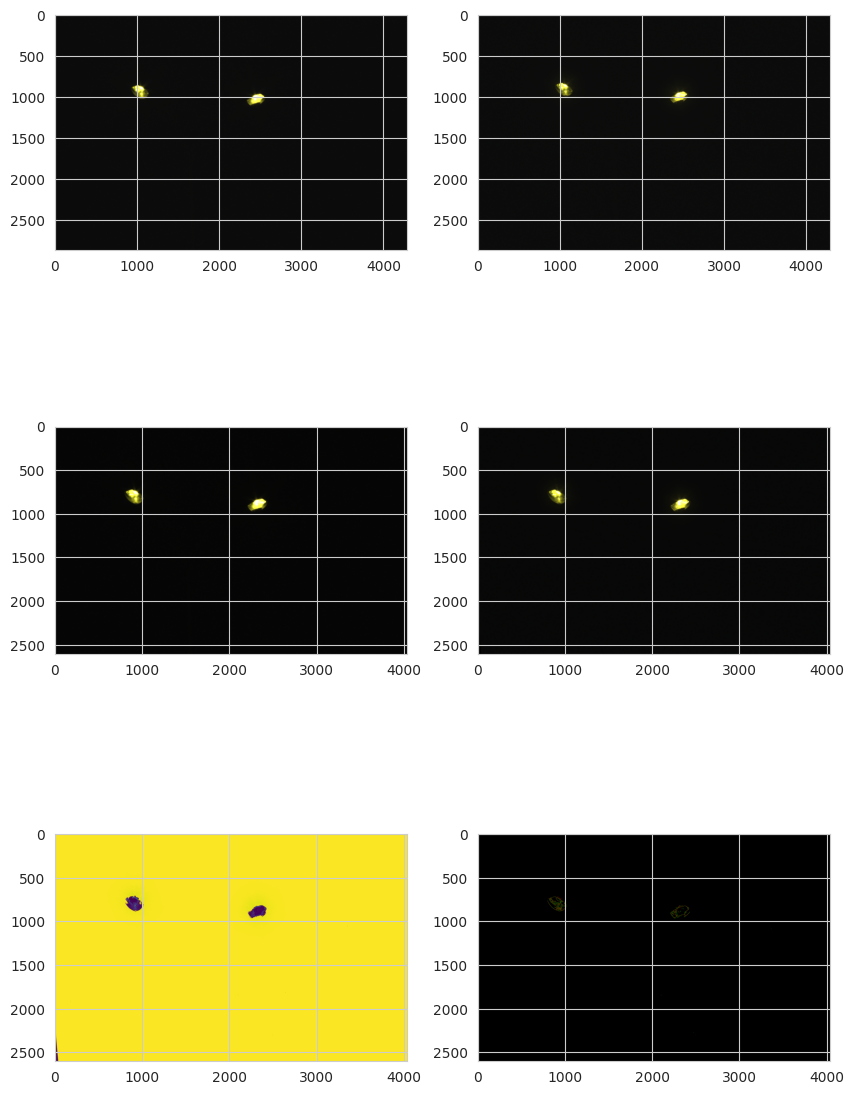

In [126]:
visualize_alignment(46)

In [149]:
from alignment import align_and_crop_raw_images

def calculate_alignment_mmsis_different_sigmas():
    raw_image_paths = get_image_paths()
    long_exp_paths = raw_image_paths['long_exp']
    filtered_paths = raw_image_paths['filter_long_exp']
    n = len(long_exp_paths)
    sigmas = [0.5, 1, 1.5, 2, 4, 8]
    ssims = [np.zeros(n) for _ in range(len(sigmas))] 
    
    for idx, (long_path, filtered_path) in tqdm(enumerate(zip(long_exp_paths, filtered_paths)), total=n):
        # Load raw images into 4 channels
        long_packed = pack_raw(rawpy.imread(long_path).raw_image_visible)
        filtered_packed = pack_raw(rawpy.imread(filtered_path).raw_image_visible)
        # Rescale for alignment algs
        long_g = (long_packed[:,:,1]/long_packed[:,:,1].max()*255).astype(np.uint8)
        filtered_g = (filtered_packed[:,:,1]/filtered_packed[:,:,1].max()*255).astype(np.uint8)
        # Align and crop
        try:
            H, ratio = get_image_alignment_transform(long_g, filtered_g, 'orb', return_ratio=True)
            aligned = apply_transform(long_packed, filtered_packed, H)
            long_packed, aligned = crop_zero_sides(long_packed, aligned, 100)
        except Exception as e:
            print("Skipping because of:", e)
            continue
        # Calculate metrics
        for s_idx, sigma in enumerate(sigmas):
            ssims[s_idx][idx] = skimage.metrics.structural_similarity(long_packed, aligned, channel_axis=2, sigma=sigma, gaussian_weights=True)

    return ssims

In [150]:
ssims = calculate_alignment_mmsis_different_sigmas()

100%|██████████| 77/77 [10:36<00:00,  8.27s/it]


In [152]:
sigmas = [0.5, 1, 1.5, 2, 4, 8]
for idx, sigma in enumerate(sigmas):
    print(f"sigma: {sigma} has avg ssim {ssims[idx].mean()}")

sigma: 0.5 has avg ssim 0.991294978863248
sigma: 1 has avg ssim 0.9898541235451246
sigma: 1.5 has avg ssim 0.9892221974486465
sigma: 2 has avg ssim 0.9888120853592223
sigma: 4 has avg ssim 0.9878315796786162
sigma: 8 has avg ssim 0.9868858987300853
